In [1]:
import pandas as pd
from tqdm import tqdm
import regex as re
import nltk
from nltk.tokenize import RegexpTokenizer
from collections import Counter
from nltk import sent_tokenize, word_tokenize

In [82]:
df = pd.read_csv("../data/labeledTrainData.tsv", sep='\t')
len(df)

25000

In [3]:
words = ['It', 'has', 'many', 'permissions']
allowed = {'JJ', 'RB'}

tags = nltk.pos_tag(words)
print(tags)
a = list(filter(lambda x: x[1] in allowed, tags))
fwords, ftags = zip(*a)
print(fwords)
print(ftags)

[('It', 'PRP'), ('has', 'VBZ'), ('many', 'JJ'), ('permissions', 'NNS')]
('many',)
('JJ',)


In [4]:
all_grams = []
allowed_tags = {'JJ', 'JJ NN', 'JJ NNS', 'JJ NN NN', 'RB JJ NN', 'JJ TO VB', 'VB JJ NN'}
banned_words = {'', 'br'}

def filter_banned_words(words, banned_words):
    filtered_words = list(filter(lambda x: x not in banned_words, words))
    
    return filtered_words

def merge_n_grams(ngrams, ntags):
    merged_n_grams = []
    merged_n_tags = []
    
    for ngram, ntag in zip(ngrams, ntags):
        merged_n_grams.append(' '.join(ngram))
        merged_n_tags.append(' '.join(ntag))
        
    return merged_n_grams, merged_n_tags

def filter_by_tags(ngrams, ntags, allowed_tags):
    pos = zip(ngrams, ntags)
    
    filtered_pos = list(filter(lambda x: len(x[0]) > 1 and x[1] in allowed_tags, pos))
    
    # filtered tags and words
    filtered_words = [word for word, tag in filtered_pos]
    filtered_tags = [tag for word, tag in filtered_pos]
    
    return filtered_words, filtered_tags

def generate_words_and_tags(review):
    sentences = sent_tokenize(review)
    
    # pos tagging and filtering
    pos_tags = []
    for sentence in sentences:
        split_words = [re.sub(r"\p{P}+", "", x).lower() for x in sentence.split()]
        words = filter_banned_words(split_words, banned_words)
        pos_tags.extend(nltk.pos_tag(words))
    
    # split words and tags
    words = [word.lower() for word, tag in pos_tags]
    tags = [tag for word, tag in pos_tags]
    
    return words, tags

def generate_n_grams(words, tags, n=1):
    if n == 1:
        ngrams, ntags = filter_by_tags(words, tags, allowed_tags)
    elif n == 2:
        bigrams = zip(words, words[1:])
        bitags = zip(tags, tags[1:])
        
        mbigrams, mbitags = merge_n_grams(bigrams, bitags)
        ngrams, ntags = filter_by_tags(mbigrams, mbitags, allowed_tags)
    elif n == 3:
        trigrams = zip(words, words[1:], words[2:])
        tritags = zip(tags, tags[1:], tags[2:])

        mtrigrams, mtritags = merge_n_grams(trigrams, tritags)
        ngrams, ntags = filter_by_tags(mtrigrams, mtritags, allowed_tags)
    
    return ngrams, ntags
    

def extend_all_grams(review, all_grams):
    words, tags = generate_words_and_tags(review)
    
    # creation of unigrams, bigrams and trigrams
    unigrams, utags = filter_by_tags(words, tags, allowed_tags)
    bigrams = zip(words, words[1:])
    bitags = zip(tags, tags[1:])
    trigrams = zip(words, words[1:], words[2:])
    tritags = zip(tags, tags[1:], tags[2:])
    
    mbigrams, mbitags = merge_n_grams(bigrams, bitags)
    fbigrams, fbitags = filter_by_tags(mbigrams, mbitags, allowed_tags)
    mtrigrams, mtritags = merge_n_grams(trigrams, tritags)
    ftrigrams, ftritags = filter_by_tags(mtrigrams, mtritags, allowed_tags)
    
    #all_grams.extend(list(set(unigrams)))
    all_grams.extend(list(set(fbigrams)))
    all_grams.extend(list(set(ftrigrams)))

In [27]:
unigrams = []
bigrams = []
trigrams = []
all_grams = []

for i in tqdm(range(len(df))):
    words, tags = generate_words_and_tags(df.iloc[i]['review'])
    
    unigrams.extend(generate_n_grams(words, tags, 1)[0])
    bigrams.extend(generate_n_grams(words, tags, 2)[0])
    trigrams.extend(generate_n_grams(words, tags, 3)[0])

100%|██████████| 25000/25000 [09:30<00:00, 43.80it/s]


In [28]:
print(len(unigrams))
print(len(bigrams))
print(len(trigrams))

539647
331314
81647


In [29]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

1764


Text(0.5,0,'Unigram counts')

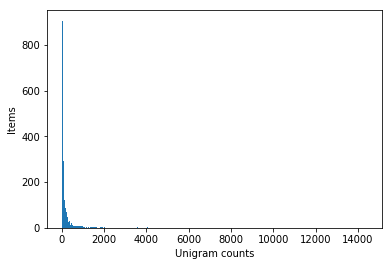

In [30]:
unigram_counts = [x for x in list(Counter(unigrams).values()) if x > 30]
print(len(unigram_counts))
plt.hist(unigram_counts, bins=300)
plt.ylabel('Items')
plt.xlabel('Unigram counts')

6246


Text(0.5,0,'Bigram counts')

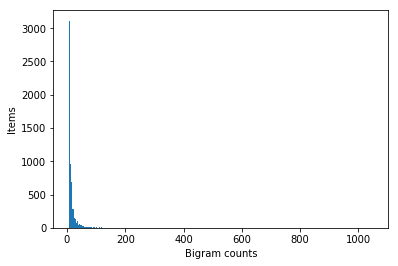

In [31]:
bigram_counts = [x for x in list(Counter(bigrams).values()) if x > 5]
print(len(bigram_counts))
plt.hist(bigram_counts, bins=300)
plt.ylabel('Items')
plt.xlabel('Bigram counts')

1700


Text(0.5,0,'Trigram counts')

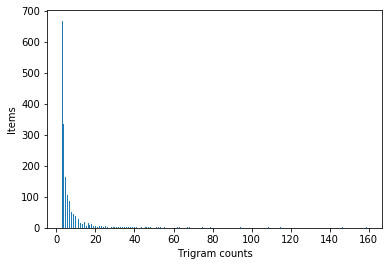

In [32]:
trigram_counts = [x for x in list(Counter(trigrams).values()) if x > 2]
print(len(trigram_counts))
plt.hist(trigram_counts, bins=300)
plt.ylabel('Items')
plt.xlabel('Trigram counts')

In [53]:
allowed_unigrams = {word : count for word, count in list(Counter(unigrams).items()) if count > 30}
allowed_bigrams = {word : count for word, count in list(Counter(bigrams).items()) if count > 5}
allowed_trigrams = {word : count for word, count in list(Counter(trigrams).items()) if count > 2}

filtered_unigrams = [x for x in unigrams if x in allowed_unigrams]
filtered_bigrams = [x for x in bigrams if x in allowed_bigrams]
filtered_trigrams = [x for x in trigrams if x in allowed_trigrams]

all_grams = []
all_grams.extend(filtered_unigrams)
all_grams.extend(filtered_bigrams)
all_grams.extend(filtered_trigrams)

In [54]:
from collections import Counter

counts = Counter(all_grams)

In [55]:
counts.most_common(5000)

[('good', 14415),
 ('other', 8911),
 ('bad', 8886),
 ('great', 8841),
 ('first', 6641),
 ('many', 6575),
 ('<br', 5990),
 ('little', 5869),
 ('much', 5810),
 ('real', 4508),
 ('new', 4225),
 ('such', 4164),
 ('few', 4044),
 ('old', 4019),
 ('same', 4002),
 ('><br', 3625),
 ('young', 3582),
 ('funny', 3426),
 ('big', 3325),
 ('original', 3264),
 ('only', 3202),
 ('own', 3125),
 ('last', 2877),
 ('whole', 2771),
 ('ive', 2553),
 ('different', 2341),
 ('main', 2248),
 ('true', 2224),
 ('interesting', 2157),
 ('hard', 2020),
 ('american', 2018),
 ('special', 2014),
 ('beautiful', 1956),
 ('sure', 1922),
 ('excellent', 1905),
 ('nice', 1888),
 ('black', 1862),
 ('high', 1859),
 ('long', 1829),
 ('poor', 1826),
 ('second', 1682),
 ('short', 1645),
 ('wrong', 1617),
 ('full', 1617),
 ('dead', 1594),
 ('classic', 1579),
 ('small', 1574),
 ('terrible', 1561),
 ('wonderful', 1554),
 ('stupid', 1539),
 ('next', 1502),
 ('awful', 1481),
 ('entire', 1459),
 ('human', 1430),
 ('>the', 1412),
 ('seve

In [56]:
counts.most_common()[-100:]

[('hard to predict', 3),
 ('want to see', 3),
 ('just dont try', 3),
 ('completely different direction', 3),
 ('brian van holt', 3),
 ('difficult to write', 3),
 ('unable to bring', 3),
 ('final fantasy vii', 3),
 ('close to be', 3),
 ('very different movie', 3),
 ('hong kong cinema', 3),
 ('great supporting cast', 3),
 ('great movie dont', 3),
 ('very good drama', 3),
 ('olivia newton john', 3),
 ('melodramatic hollywood production', 3),
 ('very satisfying film', 3),
 ('impossible to guess', 3),
 ('too much screen', 3),
 ('easy to dismiss', 3),
 ('dumb to believe', 3),
 ('nice to say', 3),
 ('short to be', 3),
 ('only thing worse', 3),
 ('impossible to turn', 3),
 ('pretty low budget', 3),
 ('able to salvage', 3),
 ('absolutely terrible i', 3),
 ('very simple story', 3),
 ('albert rupert friend', 3),
 ('modesty blaise character', 3),
 ('very straight forward', 3),
 ('not much tension', 3),
 ('slow motion versus', 3),
 ('difficult to figure', 3),
 ('slow pace i', 3),
 ('american pie fr

In [57]:
DIRECTORY = '/mnt/c/Users/gvs/ubuntu/neural-review-summarization/output/'
FILE_NAME = 'important_phrases.csv'
UNIGRAMS_FILE = 'unigrams.csv'
BIGRAMS_FILE = 'bigrams.csv'
TRIGRAMS_FILE = 'trigrams.csv'

n_gram_counts = [Counter(filtered_unigrams), Counter(filtered_bigrams), Counter(filtered_trigrams)]
N_GRAM_FILES = [UNIGRAMS_FILE, BIGRAMS_FILE, TRIGRAMS_FILE]

In [74]:
df = pd.DataFrame.from_dict(counts, orient='index').reset_index()
df = df.rename(columns={'index':'Phrase', 0:'Count'})

In [75]:
df.to_csv(DIRECTORY + FILE_NAME, encoding='utf-8')

In [76]:
for i in range(len(N_GRAM_FILES)):
    n_gram_file = N_GRAM_FILES[i]
    n_gram_count = n_gram_counts[i]
    
    n_gram_df = pd.DataFrame.from_dict(n_gram_count, orient='index').reset_index()
    n_gram_df = n_gram_df.rename(columns={'index':'Phrase', 0:'Count'})
    n_gram_df.to_csv(DIRECTORY + n_gram_file, encoding='utf-8')    

In [83]:
df = pd.read_csv(DIRECTORY + FILE_NAME)
unigram_df = pd.read_csv(DIRECTORY + UNIGRAMS_FILE)
bigram_df = pd.read_csv(DIRECTORY + BIGRAMS_FILE)
trigram_df = pd.read_csv(DIRECTORY + TRIGRAMS_FILE)

In [84]:
import numpy as np

def load_glove_model(glove_file):
    print("Loading Glove Model")
    with open(glove_file,'r') as f:
        model = {}
        for line in tqdm(f):
            split_line = line.split()
            word = split_line[0]
            embedding = np.array([float(val) for val in split_line[1:]])
            model[word] = embedding
            
    print("Done.",len(model)," words loaded!")
    return model

In [85]:
GLOVE_DIR = '/home/gvs/neural-review-summarization/model/embeddings/'
GLOVE_FILE = 'glove.6B.300d.txt'
glove = load_glove_model(GLOVE_DIR + GLOVE_FILE)

678it [00:00, 6712.15it/s]

Loading Glove Model


400000it [01:01, 6481.00it/s]

Done. 400000  words loaded!


In [104]:
from sklearn.preprocessing import normalize

def vectorize_phrase(string_phrase, emb_size=300):
    emb_sum = None
    keys = string_phrase.split()
    
    all_in_glove = True
    
    for key in keys:
        if key not in glove:
            all_in_glove = False
            break
    
    if all_in_glove:
        emb_sum = np.zeros(emb_size)
        
        for key in keys:
            vec = glove[key]
            emb_sum += vec

        emb_sum /= len(keys)
        emb_sum = normalize(emb_sum[:,np.newaxis], axis=0).ravel()
    
        """
        norm = np.linalg.norm(emb_sum)
        if norm!=0:
            emb_sum /= np.linalg.norm(norm)
        """
    
    return emb_sum
    
emb_size = len(glove['hi'])

def generate_phrase_meanings(df, emb_size=300):
    meanings = []
    meaning_labels = []
    for i in tqdm(range(len(df))):    
        string_phrase =  df.iloc[i]['Phrase']

        vectorized_phrase = vectorize_phrase(string_phrase, emb_size=emb_size)

        if vectorized_phrase is not None:
            meaning_labels.append(string_phrase)
            meanings.append(vectorized_phrase)
    
    return meanings, meaning_labels

meanings, meaning_labels = generate_phrase_meanings(df, emb_size=emb_size)
bi_meanings, bi_meaning_labels = generate_phrase_meanings(bigram_df, emb_size=emb_size)

100%|██████████| 6246/6246 [00:02<00:00, 2194.40it/s]


In [100]:
import numpy as np
from sklearn.metrics.pairwise import cosine_distances
from scipy import spatial

print(df.iloc[0])
print(df.iloc[5])

print(1 - spatial.distance.cosine(meanings[0], meanings[5]))

Unnamed: 0             0
Phrase        major role
Count                 19
Name: 0, dtype: object
Unnamed: 0           5
Phrase        same age
Count               22
Name: 5, dtype: object
0.390206998104


In [101]:
print(len(meanings))
print(len(bi_meanings))

9307
6002


In [46]:
from sklearn import cluster

k = 300
kmeans = cluster.KMeans(n_clusters=k, max_iter=300, n_init=5, n_jobs=2, verbose=1)
kmeans.fit_predict(meanings)

Initialization complete
Initialization complete
start iteration
done sorting
end inner loop
start iteration
done sorting
end inner loop
Iteration 0, inertia 3078.63531119
start iteration
done sorting
Iteration 0, inertia 3114.05207737
start iteration
done sorting
end inner loop
Iteration 1, inertia 2891.27106712
start iteration
done sorting
end inner loop
Iteration 1, inertia 2913.70574017
start iteration
done sorting
end inner loop
Iteration 2, inertia 2844.76242709
start iteration
done sorting
end inner loop
Iteration 2, inertia 2858.85493555
start iteration
done sorting
end inner loop
Iteration 3, inertia 2822.78264624
start iteration
done sorting
end inner loop
Iteration 3, inertia 2835.21554994
start iteration
end inner loop
done sorting
Iteration 4, inertia 2810.44690853
start iteration
done sorting
end inner loop
end inner loop
Iteration 4, inertia 2821.88804122
start iteration
Iteration 5, inertia 2803.69910131
done sorting
start iteration
done sorting
end inner loop
end inner 

start iteration
done sorting
end inner loop
Iteration 0, inertia 3100.0236877
start iteration
done sorting
end inner loop
Iteration 1, inertia 2894.01723954
start iteration
done sorting
end inner loop
Iteration 2, inertia 2841.2952562
start iteration
done sorting
end inner loop
Iteration 3, inertia 2819.8981364
start iteration
done sorting
end inner loop
Iteration 4, inertia 2807.88322778
start iteration
done sorting
end inner loop
Iteration 5, inertia 2800.67038096
start iteration
done sorting
end inner loop
Iteration 6, inertia 2795.29803294
start iteration
done sorting
end inner loop
Iteration 7, inertia 2790.12875118
start iteration
done sorting
end inner loop
Iteration 8, inertia 2786.33295659
start iteration
done sorting
end inner loop
Iteration 9, inertia 2783.46026046
start iteration
done sorting
end inner loop
Iteration 10, inertia 2781.50396282
start iteration
done sorting
end inner loop
Iteration 11, inertia 2780.74546109
start iteration
done sorting
end inner loop
Iteration

array([ 86,  72, 154, ..., 130, 139, 184], dtype=int32)

In [47]:
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
print(len(meaning_labels))

8017


In [176]:
from sklearn import cluster



def cluster_meanings(meanings):
    k = 600
    
    cl = cluster.AgglomerativeClustering(n_clusters=k, affinity='cosine', linkage='average')
    #cl = cluster.KMeans(n_clusters=k, max_iter=300, n_init=5, n_jobs=2, verbose=1)
    #cl = cluster.DBSCAN(algorithm='auto', eps=0.4, leaf_size=20, min_samples=3, metric='cosine')
    cl.fit_predict(meanings)
    
    return cl

In [177]:
cl = cluster_meanings(bi_meanings)

labels = cl.labels_
k = len(list(set(labels)))
print(k)
print(len(meaning_labels))
#centroids = cl.cluster_centers_

600
9307


In [159]:
def print_phrase_and_clusters(phrases, cluster_labels, show=1000):
    for i in range(show):
        print(phrases[i], cluster_labels[i])
        
def generate_cluster_examples(meaning_labels, cluster_labels):
    cluster_examples = {}

    for i in range(len(cluster_labels)):
        if cluster_labels[i] not in cluster_examples:
            cluster_examples[cluster_labels[i]] = []

        cluster_examples[cluster_labels[i]].append(meaning_labels[i])
        
    return cluster_examples
        
def print_clusters_examples(cluster_examples, cluster_counts, k, show=30):
    for pair in cluster_counts.most_common(k):
        cluster_label, _ = pair

        print("\nPrinting examples for cluster {}:".format(cluster_label))

        size = min(show, len(cluster_examples[cluster_label]))
        for i in range(size):
            print(cluster_examples[cluster_label][i])

In [178]:
cluster_counts = Counter(labels)
print(cluster_counts.most_common(k))

cluster_examples = generate_cluster_examples(bi_meaning_labels, labels)

print_clusters_examples(cluster_examples, cluster_counts, k)

[(16, 880), (21, 489), (7, 430), (72, 292), (22, 227), (35, 163), (83, 118), (80, 102), (5, 82), (84, 74), (68, 70), (34, 69), (37, 69), (50, 68), (40, 67), (2, 65), (54, 54), (73, 53), (12, 51), (129, 48), (170, 44), (61, 40), (144, 40), (128, 35), (74, 33), (296, 30), (6, 29), (103, 29), (93, 28), (131, 28), (136, 26), (137, 26), (194, 26), (259, 26), (20, 25), (69, 25), (30, 23), (47, 22), (65, 22), (104, 22), (109, 21), (294, 21), (27, 20), (86, 20), (105, 20), (108, 20), (118, 19), (148, 19), (254, 19), (139, 18), (45, 17), (58, 17), (126, 17), (179, 17), (242, 17), (277, 17), (510, 17), (135, 16), (33, 15), (67, 15), (115, 15), (169, 15), (49, 14), (88, 14), (97, 14), (3, 13), (24, 13), (141, 13), (204, 13), (13, 12), (75, 12), (100, 12), (116, 12), (146, 12), (163, 12), (229, 12), (293, 12), (19, 11), (79, 11), (202, 11), (212, 11), (598, 11), (10, 10), (41, 10), (51, 10), (70, 10), (122, 10), (190, 10), (237, 10), (290, 10), (11, 9), (39, 9), (42, 9), (43, 9), (59, 9), (99, 9),

wooden performances
wooden horse
wooden acting

Printing examples for cluster 247:
top gun
gun battle
naked gun

Printing examples for cluster 251:
invisible man
invisible boy
invisible ray

Printing examples for cluster 252:
san diego
san francisco
los angeles

Printing examples for cluster 264:
international pictures
international film
republic pictures

Printing examples for cluster 266:
steve buscemi
steve biko
steve martin

Printing examples for cluster 270:
welcome addition
refreshing change
welcome change

Printing examples for cluster 274:
stop motion
slow motion
major motion

Printing examples for cluster 288:
laugh track
laugh riot
single laugh

Printing examples for cluster 322:
fairy tales
fairy tale
cautionary tale

Printing examples for cluster 330:
stephen rea
stephen king
stephen kings

Printing examples for cluster 353:
mobile phone
mobile suits
mobile suit

Printing examples for cluster 422:
big ben
ben chaplin
ben stiller

Printing examples for cluster 449:
nick stah

In [172]:
print_phrase_and_clusters(bi_meaning_labels, labels)

major role 14
asian cinema 14
clean fun 14
serious attempt 14
certain sequences 14
same age 14
awful lot 14
first taste 14
total recall 14
false move 14
main feature 14
barbara stanwyck 20
mad scientist 14
good grief 14
possible way 14
dramatic performance 14
interesting story 14
difficult times 14
pretty boy 14
several friends 14
early morning 14
nuclear war 14
first films 14
same line 14
normal movie 14
other show 14
fifty years 14
old days 14
todays world 50
sure everyone 14
great dancer 14
same sort 14
last third 14
dolph lundgren 1
graphic novel 14
major star 14
short while 14
sarah silverman 20
decent performance 14
same time 14
much everything 14
first words 14
dont worry 16
old folks 14
nice turn 14
little man 14
own movies 14
sean penn 3
pneumonic plague 79
main protagonists 14
sad movie 14
final death 14
unknown cast 14
high tech 14
laugh track 14
interesting camera 14
illegal immigrant 14
unknown man 14
separate ways 14
physical appearance 14
original language 14
early role 

In [28]:
DIRECTORY = '/mnt/c/Users/gvs/ubuntu/neural-review-summarization/output/'
KMEANS_MODEL_FILE = "k_means_model.pkl"

In [32]:
import pickle

"""
with open(DIRECTORY + KMEANS_MODEL_FILE, 'wb') as model_file:
    pickle.dump(kmeans, model_file, protocol=pickle.HIGHEST_PROTOCOL)
    print('model saved')
"""

In [51]:
test_df = pd.DataFrame.from_csv("../data/test_midnight_cowboy.tsv", sep='\t', encoding='latin-1')

/home/gvs/.virtualenvs/neural-review-summarization/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.


In [54]:
test_all_grams = []
for i in tqdm(range(len(test_df))):
    extend_all_grams(test_df.iloc[i]['review'], test_all_grams)

100%|██████████| 80/80 [00:02<00:00, 35.96it/s]


In [55]:
test_counts = Counter(test_all_grams)
print(test_counts.most_common(40))

[('new york', 46), ('new york city', 23), ('joe buck', 13), ('first time', 10), ('main characters', 8), ('dustin hoffman', 8), ('big city', 7), ('big apple', 6), ('great movie', 5), ('academy award', 5), ('young man', 5), ('late 60s', 4), ('psychedelic party', 4), ('male prostitute', 4), ('whole film', 4), ('main character', 4), ('late 1960s', 4), ('ratso rizzo', 4), ('simple story', 3), ('same way', 3), ('new yorkers', 3), ('long time', 3), ('small town', 3), ('naive joe', 3), ('only thing', 3), ('other times', 3), ('new york joe', 3), ('late sixties', 3), ('i dont', 3), ('new yorker', 3), ('real world', 3), ('old man', 3), ('first x', 2), ('taboo subjects', 2), ('close friendship', 2), ('whole midnight cowboy', 2), ('great performances', 2), ('fantastic movie', 2), ('easy rider', 2), ('enough money', 2)]


In [56]:
with open(DIRECTORY + KMEANS_MODEL_FILE, 'rb') as model_file:
    kmeans = pickle.load(model_file)

NameError: name 'KMEANS_MODEL_FILE' is not defined

In [57]:
manual_phrases = ['fundamental problems', 'unrelenting tedium', 'most horrible blockbuster']

vectorized_phrases = []
test_labels = []

for phrase in test_all_grams:
    vectorized_phrase = vectorize_phrase(phrase)
    if vectorized_phrase is not None:
        vectorized_phrases.append(vectorized_phrase)
        test_labels.append(phrase)

In [58]:
test_predictions = kmeans.predict(vectorized_phrases)
print(test_predictions)

[ 91  61  46 ..., 164 183 243]


In [59]:
Counter(test_predictions).most_common(30)

[(164, 102),
 (152, 57),
 (251, 35),
 (177, 34),
 (224, 31),
 (165, 27),
 (8, 24),
 (46, 23),
 (21, 21),
 (112, 21),
 (167, 20),
 (281, 20),
 (256, 19),
 (82, 18),
 (176, 18),
 (261, 18),
 (95, 17),
 (96, 17),
 (187, 17),
 (5, 16),
 (74, 16),
 (126, 16),
 (162, 16),
 (70, 15),
 (288, 15),
 (40, 14),
 (128, 14),
 (255, 14),
 (20, 13),
 (30, 13)]

In [60]:
good_clusters = {100, 210, 228, 265, 313, 328, 389, 417, 426, 563, 142, 12, 142, 336, 531, 487, 474, 463, 469, 494, 592, 0, 1, 13, 163, 267, 322}
bad_clusters = {199, 329, 425, 497, 517, 555, 580, 479, 250, 495, 279, 124, 506, 94, 212, 55, 250, 131, 232, 122, 20, 289, 327,}
filtered_labels = []

for i in range(len(test_predictions)):
    test_prediction = test_predictions[i]
    
    if test_prediction in good_clusters:
        filtered_labels.append(test_labels[i])

test_labels_count = Counter(filtered_labels)
print(test_labels_count)

Counter({'real world': 3, 'new world': 2, 'jaded world': 1, 'hard to find': 1, 'next to joe': 1, 'horrible etc': 1, 'moving world': 1, 'hard to see': 1, 'comic relief': 1, 'same world': 1, 'professional reviewer': 1, 'horrible situation': 1, 'realistic portrait': 1, 'late to back': 1, 'future reviews': 1, 'outstanding cast': 1, 'entire cast': 1, 'hostile world': 1, 'indifferent world': 1, 'hard to make': 1, 'other reviewers': 1, 'terrible feeling': 1, 'sympathetic figures': 1, 'uncompromising examination': 1, 'hard way': 1, 'new world thinking': 1, 'afi critics': 1, 'urban world': 1, 'understatement to say': 1, 'excellent support cast': 1, 'hard edge': 1, 'sad to say': 1, 'stupid to understand': 1, 'happy to let': 1, 'sure to shock': 1})


In [195]:
clustered_predictions = {}
clustered_predictions_weights = {}

for i in range(len(test_predictions)):
    test_prediction = test_predictions[i]
    
    if test_prediction in good_clusters:
        if test_prediction not in clustered_predictions:
            clustered_predictions[test_prediction] = set()
            clustered_predictions_weights[test_prediction]= 0
        
        clustered_predictions[test_prediction].add(test_labels[i])
        clustered_predictions_weights[test_prediction] += test_labels_count[test_labels[i]]
        
print(clustered_predictions)
print(clustered_predictions_weights)

important_clusters = []
for key in clustered_predictions_weights.keys():
    important_clusters.append((clustered_predictions_weights[key], clustered_predictions[key]))

important_clusters.sort(key=lambda tup: tup[0], reverse=True)

for count, phrase_set in important_clusters:
    print('Printing the cluster with {} mentions'.format(count))
    
    for key in list(phrase_set):
        print(key)
    
    print('')

#print(important_clusters)

{0: {'abominable film', 'boring film'}, 417: {'cleverness comedy', 'lame cop comedy'}, 322: {'curious to see'}, 163: {'puerile immature line', 'puerile immature'}, 228: {'weird character'}, 389: {'lame cop', 'gags lame'}, 487: {'sexual innuendos'}, 328: {'awful lines'}, 265: {'few films', 'bad films'}, 426: {'bad comedian'}, 12: {'acclaimed tv', 'jurassic park tv', 'spielberg tv', 'spielberg tv show'}, 13: {'many concepts', 'many occasions'}, 142: {'good idea', 'good reasons', 'good blend', 'good jokes', 'good category'}, 531: {'big tax', 'big tax writeoff', 'big steal'}, 336: {'actual film'}, 210: {'bad dinosaur', 'particularly bad episode', 'bad buddy', 'bad guys', 'bad impersonator', 'bad taste'}, 563: {'porn scenes', 'futuristic scenes'}, 313: {'special effects'}, 100: {'horrible movie', 'spielberg look trite', 'really bad movie', 'spielberg look', 'bad movie', 'painfully bad movie', 'amazing movie'}, 474: {'main characters'}}
{0: 2, 417: 5, 322: 1, 163: 8, 228: 4, 389: 5, 487: 1, 

In [153]:
kmeans.predict([vectorize_phrase("big apple")])

array([531], dtype=int32)

In [60]:
data_df = pd.DataFrame.from_csv("../data/labeledTrainData.tsv", sep='\t', header=0)

/home/gvs/.virtualenvs/neural-review-summarization/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.


In [83]:
ids = data_df.index.values
print(ids[:10])

split_ids = []
for id in ids:
    split_id = str(id).split('_')
    split_ids.append(split_id[0])
    
id_counts = Counter(split_ids)

print(id_counts.most_common(1000))

['5814_8' '2381_9' '7759_3' '3630_4' '9495_8' '8196_8' '7166_2' '10633_1'
 '319_1' '8713_10']
[('2952', 2), ('3624', 2), ('3848', 2), ('4739', 2), ('12247', 2), ('5328', 2), ('3385', 2), ('8746', 2), ('7776', 2), ('6126', 2), ('12384', 2), ('2267', 2), ('178', 2), ('4250', 2), ('2353', 2), ('5462', 2), ('477', 2), ('2687', 2), ('242', 2), ('2795', 2), ('10482', 2), ('10536', 2), ('2515', 2), ('12344', 2), ('6067', 2), ('6867', 2), ('12219', 2), ('6279', 2), ('8046', 2), ('2790', 2), ('3148', 2), ('6125', 2), ('1501', 2), ('1535', 2), ('2986', 2), ('529', 2), ('3517', 2), ('54', 2), ('162', 2), ('8059', 2), ('7011', 2), ('12472', 2), ('794', 2), ('6077', 2), ('1126', 2), ('7125', 2), ('8944', 2), ('11232', 2), ('5804', 2), ('309', 2), ('8605', 2), ('1433', 2), ('9893', 2), ('7443', 2), ('10591', 2), ('11530', 2), ('9907', 2), ('10974', 2), ('6950', 2), ('7110', 2), ('9515', 2), ('4196', 2), ('10669', 2), ('1457', 2), ('9672', 2), ('5599', 2), ('5021', 2), ('12322', 2), ('5093', 2), ('19

In [247]:
print("Top terms per cluster:")
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
print(kmeans.cluster_centers_.)
for i in range(k):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % meaning_labels[ind]),

SyntaxError: invalid syntax (<ipython-input-247-445f186ab7e3>, line 3)

In [173]:
print(1 - spatial.distance.cosine(kmeans.cluster_centers_[187], vectorize_phrase("new artwork")))

0.807326261227


In [164]:
kmeans.cluster_centers_[531]

array([  6.02488181e-03,   4.00078939e-02,  -2.34505436e-03,
        -1.30845203e-02,   5.30984175e-03,   5.20652970e-02,
         1.71046704e-03,   4.12636928e-02,  -2.77371868e-02,
        -1.57973884e-01,  -1.06839710e-02,   1.50319295e-02,
        -1.14223715e-02,   4.48585202e-02,   2.10645142e-02,
        -3.22269700e-02,  -2.67787018e-02,  -3.18474338e-02,
         4.14716724e-02,   1.85291144e-02,   6.45597273e-02,
         8.43474106e-02,   5.18868235e-02,   4.76995949e-02,
        -3.66124305e-02,   3.10804753e-02,   2.36923731e-03,
        -6.51511906e-02,   2.91555910e-02,  -1.70827616e-02,
        -5.21377058e-02,  -3.67795052e-03,  -4.93548017e-02,
         2.18489254e-02,  -2.16898291e-01,   5.39831127e-02,
        -3.73293203e-02,  -1.92715543e-02,  -2.39249771e-02,
         3.08766904e-02,  -7.42926193e-04,  -5.45357351e-02,
         3.26134134e-02,   2.96699381e-02,  -3.82175551e-02,
         2.65053214e-02,   6.40541198e-02,  -5.25016424e-02,
        -1.08542158e-02,